<a href="https://colab.research.google.com/github/IronVr/Machine_learning_technologies/blob/Neural-networks.-Autoencoders/Neural_networks_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Данный датасет содержит информацию об атрибутах людей разного пола

- **long_hair:** TЭтот столбец содержит 0 и 1, где 1 — «длинные волосы», а 0 — «не длинные волосы».
- **forehead_width_cm:** Этот столбец в см. Это ширина лба.
- **forehead_height_cm:** Это высота лба в см.
- **nose_wide:** Этот столбец содержит 0 и 1, где 1 — «широкий нос», а 0 — «не широкий нос».
- **nose_long:** Этот столбец содержит 0 и 1, где 1 — «длинный нос», а 0 — «не длинный нос».
- **lips_thin:** Этот столбец содержит 0 и 1, где 1 представляет «тонкие губы», а 0 — «не тонкие губы».
- **distance_nose_to_lip_long:** Этот столбец содержит 0 и 1, где 1 представляет «большое расстояние между носом и губами», а 0 — «короткое расстояние между носом и губами».
- **gender:** Это пол. Либо «Мужской», либо «Женский».

https://www.kaggle.com/datasets/elakiricoder/gender-classification-dataset/data

# Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков.

## Declare required dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Male", "Fеmale"]

## Data ingestion

In [2]:
df = pd.read_csv('gender.csv')

## Data exploration

In [3]:
df.head(5)

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


In [4]:
print(df.shape)
print(df.describe())

(5001, 8)
         long_hair  forehead_width_cm  forehead_height_cm    nose_wide  \
count  5001.000000        5001.000000         5001.000000  5001.000000   
mean      0.869626          13.181484            5.946311     0.493901   
std       0.336748           1.107128            0.541268     0.500013   
min       0.000000          11.400000            5.100000     0.000000   
25%       1.000000          12.200000            5.500000     0.000000   
50%       1.000000          13.100000            5.900000     0.000000   
75%       1.000000          14.000000            6.400000     1.000000   
max       1.000000          15.500000            7.100000     1.000000   

         nose_long    lips_thin  distance_nose_to_lip_long  
count  5001.000000  5001.000000                5001.000000  
mean      0.507898     0.493101                   0.498900  
std       0.499988     0.500002                   0.500049  
min       0.000000     0.000000                   0.000000  
25%       0.000000

Проверка на пропуски

In [5]:
df.isnull().values.any()

np.False_

Распределение классификации

In [6]:
df['gender'].value_counts()

gender
Female    2501
Male      2500
Name: count, dtype: int64

C:\Users\Антон\AppData\Local\Temp\ipykernel_19196\2724096439.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['gender'], sort = True)


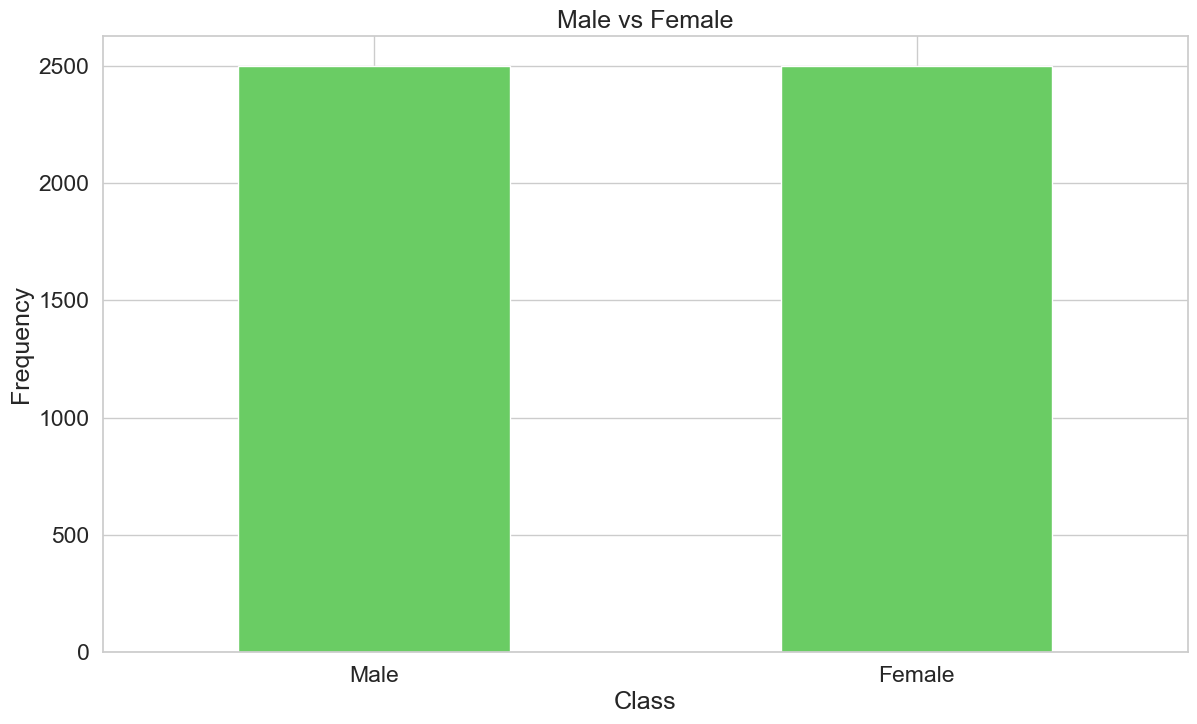

In [7]:
count_classes = pd.value_counts(df['gender'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Male vs Female")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

Наш набор данных идеально сбалансирован!

In [8]:
df['gender'] = df['gender'].replace(['Male', 'Female'], [0,1])
FemaleDF = df[df['gender'] == 1]
MaleDF = df[df['gender'] == 0]

C:\Users\Антон\AppData\Local\Temp\ipykernel_19196\2849297922.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(['Male', 'Female'], [0,1])


In [9]:
FemaleDF.shape

(2501, 8)

In [10]:
MaleDF.shape

(2500, 8)

Посмотрим распределение признаков для отдельный классов

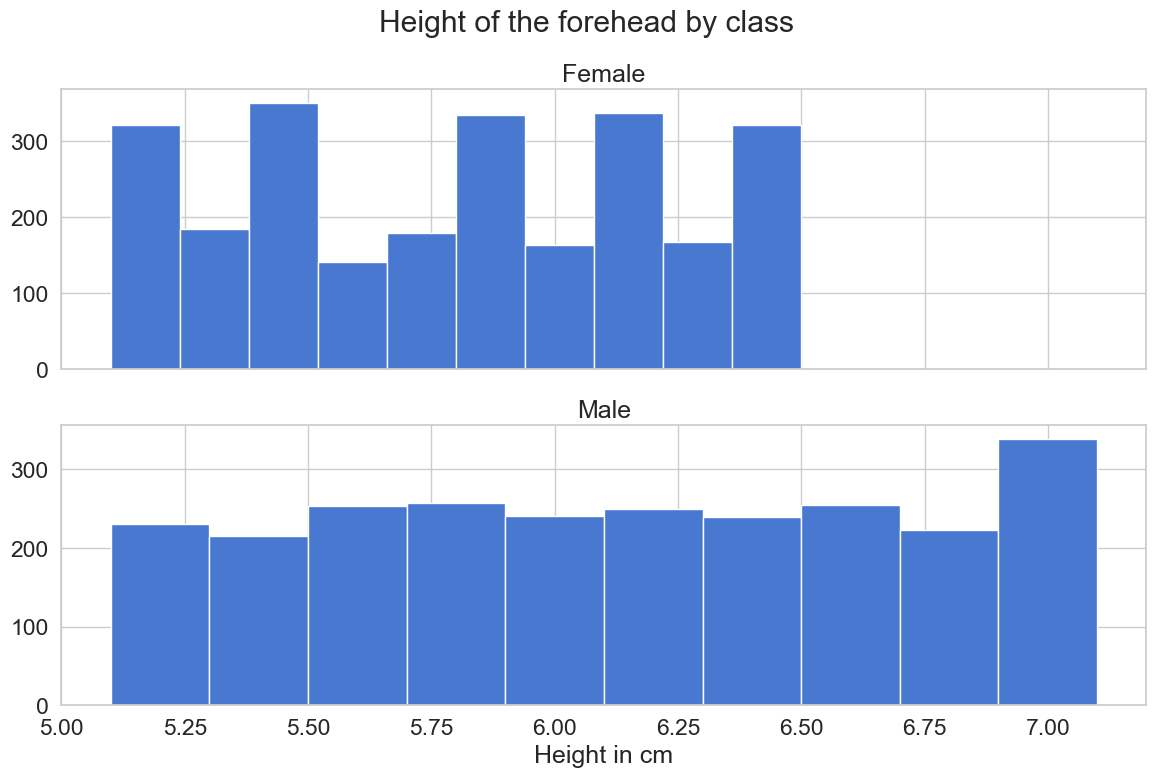

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Height of the forehead by class')

ax1.hist(FemaleDF["forehead_height_cm"])
ax1.set_title('Female')

ax2.hist(MaleDF['forehead_height_cm'])
ax2.set_title('Male')

plt.xlabel('Height in cm')
plt.show();

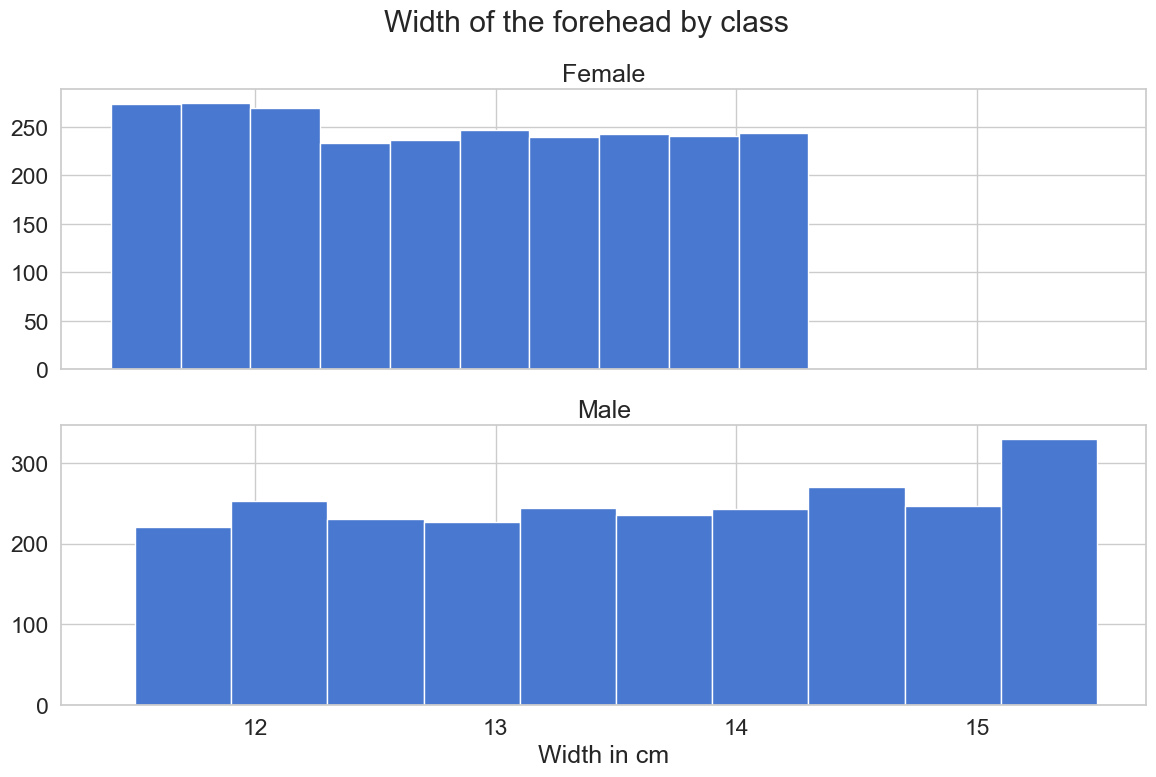

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Width of the forehead by class')

ax1.hist(FemaleDF["forehead_width_cm"])
ax1.set_title('Female')

ax2.hist(MaleDF['forehead_width_cm'])
ax2.set_title('Male')

plt.xlabel('Width in cm')
plt.show();

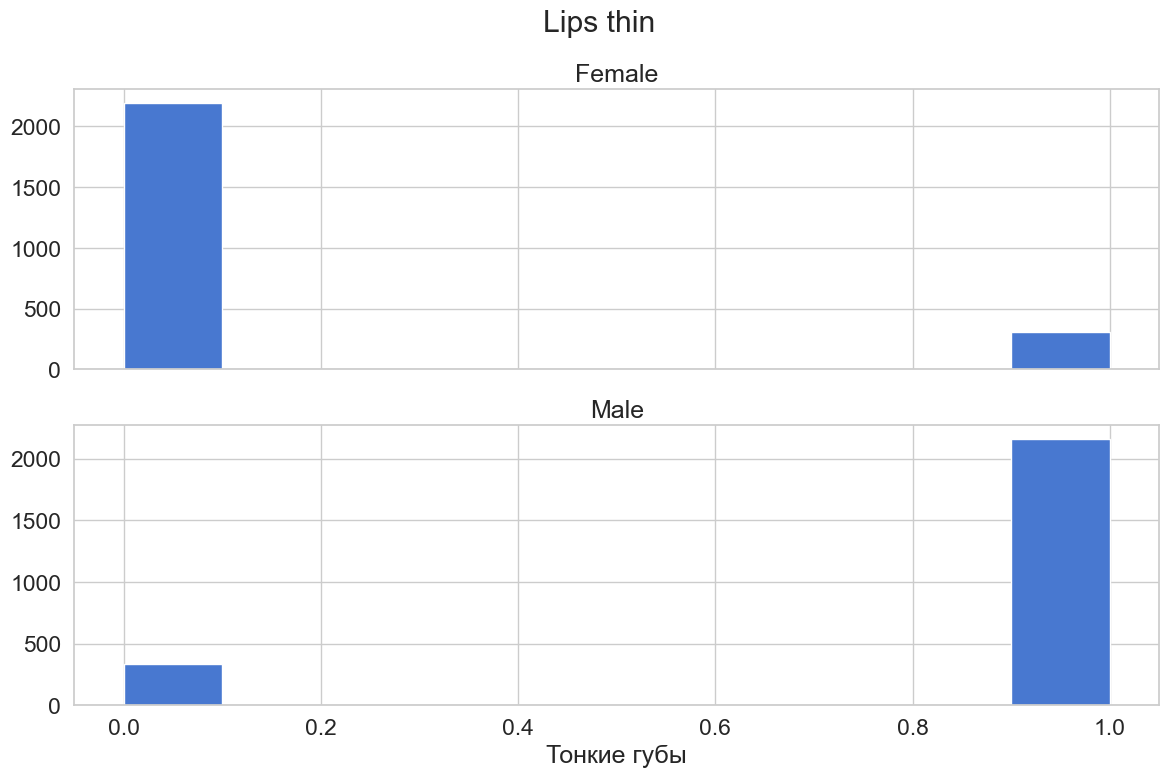

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Lips thin')

ax1.hist(FemaleDF["lips_thin"])
ax1.set_title('Female')

ax2.hist(MaleDF['lips_thin'])
ax2.set_title('Male')

plt.xlabel('Тонкие губы')
plt.show()

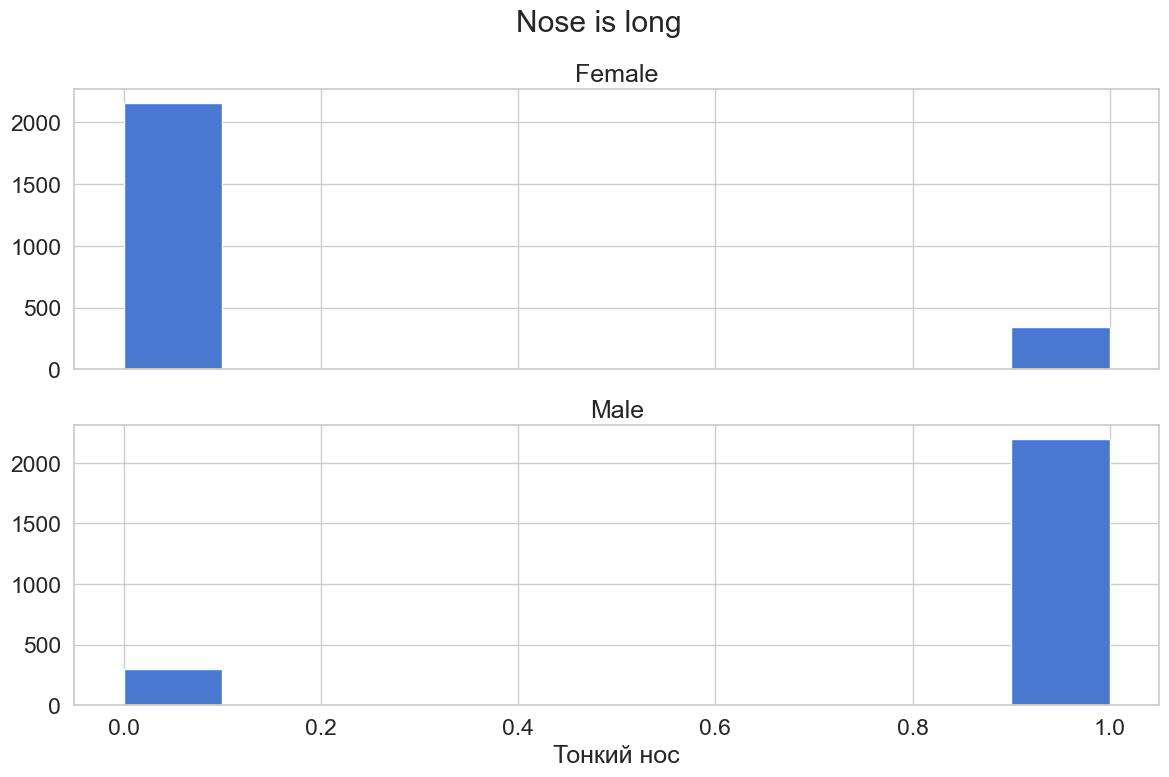

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Nose is long')

ax1.hist(FemaleDF["nose_long"])
ax1.set_title('Female')

ax2.hist(MaleDF['nose_long'])
ax2.set_title('Male')

plt.xlabel('Тонкий нос')
plt.show();

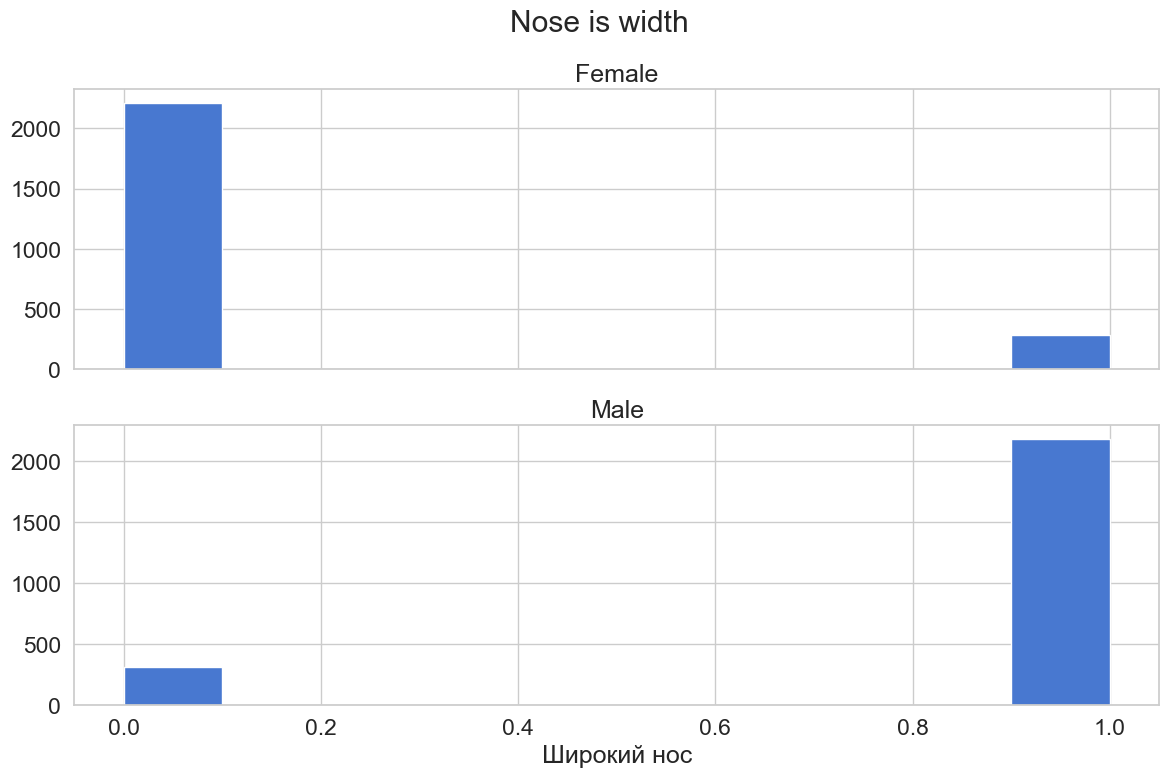

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Nose is width')

ax1.hist(FemaleDF["nose_wide"])
ax1.set_title('Female')

ax2.hist(MaleDF['nose_wide'])
ax2.set_title('Male')

plt.xlabel('Широкий нос')
plt.show();

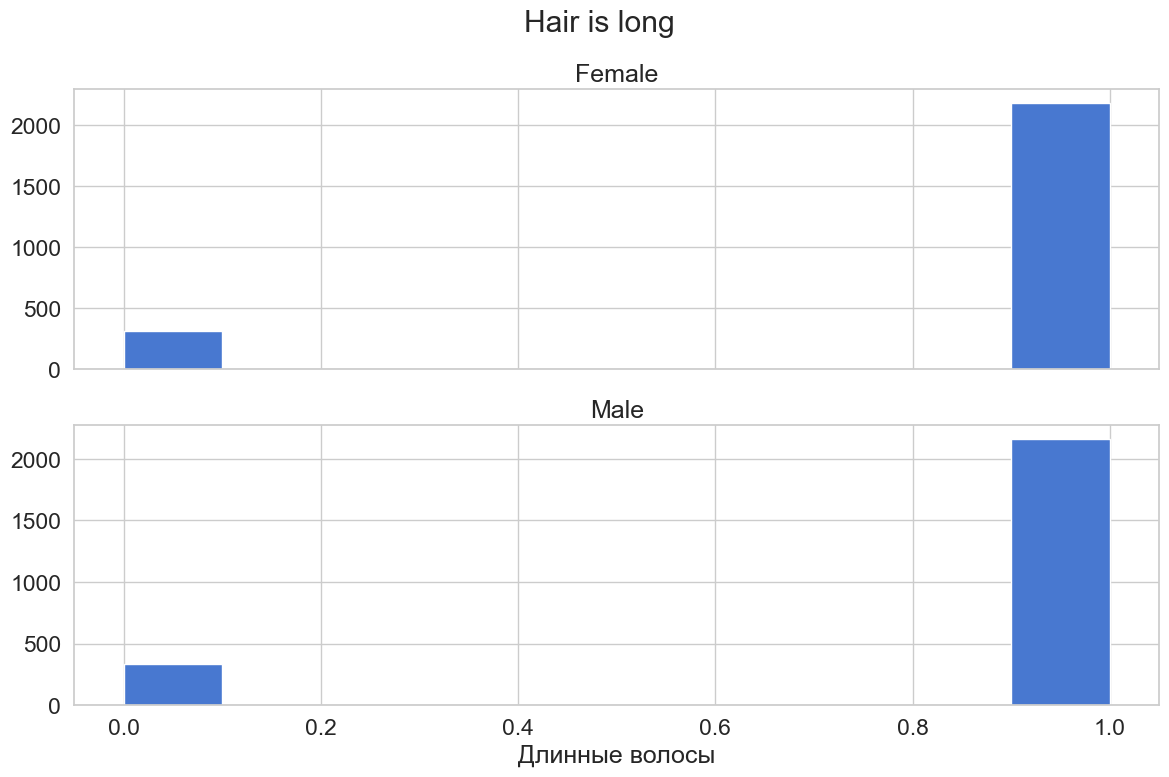

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Hair is long')

ax1.hist(FemaleDF["long_hair"])
ax1.set_title('Female')

ax2.hist(MaleDF['long_hair'])
ax2.set_title('Male')

plt.xlabel('Длинные волосы')
plt.show();


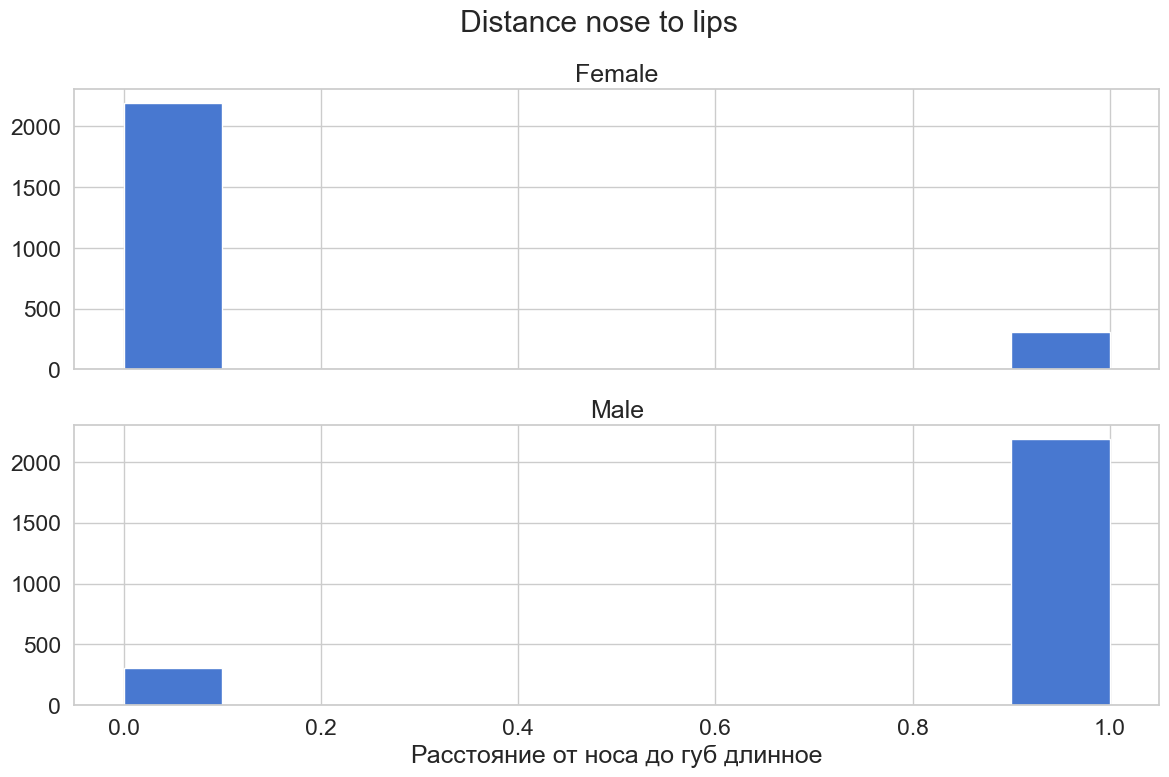

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Distance nose to lips')

ax1.hist(FemaleDF["distance_nose_to_lip_long"])
ax1.set_title('Female')

ax2.hist(MaleDF['distance_nose_to_lip_long'])
ax2.set_title('Male')

plt.xlabel('Расстояние от носа до губ длинное')
plt.show();


По график делаем вывод, что по распределению признаков для женщин и мужчин можно легко определить пол

## Preprocessing

In [18]:
newData = df

Стандартизация численных признаков

In [19]:
newData['forehead_height_cm'] = MinMaxScaler().fit_transform(newData['forehead_height_cm'].values.reshape(-1, 1))
newData['forehead_width_cm'] = MinMaxScaler().fit_transform(newData['forehead_width_cm'].values.reshape(-1, 1))


In [20]:
newData.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,0.097561,0.50,1,0,1,1,0
1,0,0.634146,0.15,0,0,1,0,1
2,0,0.097561,0.60,1,1,1,1,0
3,0,0.731707,0.50,0,1,1,1,0
4,1,0.512195,0.40,0,0,0,0,1


### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только мужчины, а в тестовом наборе данных будет оба пола.

In [21]:
X_train, X_test = train_test_split(newData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train['gender'] == 0]
X_train = X_train.drop(['gender'], axis=1)
#print(type(X_train))
y_test = X_test['gender']
X_test = X_test.drop(['gender'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


1001


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 8,7,7,7 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 7 узлов, соответствующих 7 функциям в элементе входных данных.

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7, 8),
            nn.Tanh(),
            nn.Linear(8, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 7),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
model = Autoencoder().double()

In [24]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 8
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [25]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [26]:
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [28]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './model.pth')

epoch [1/100], loss:0.1889
epoch [2/100], loss:0.0803
epoch [3/100], loss:0.0664
epoch [4/100], loss:0.0595
epoch [5/100], loss:0.0495
epoch [6/100], loss:0.0417
epoch [7/100], loss:0.0337
epoch [8/100], loss:0.0302
epoch [9/100], loss:0.0276
epoch [10/100], loss:0.0226
epoch [11/100], loss:0.0179
epoch [12/100], loss:0.0169
epoch [13/100], loss:0.0163
epoch [14/100], loss:0.0158
epoch [15/100], loss:0.0154
epoch [16/100], loss:0.0154
epoch [17/100], loss:0.0148
epoch [18/100], loss:0.0144
epoch [19/100], loss:0.0141
epoch [20/100], loss:0.0136


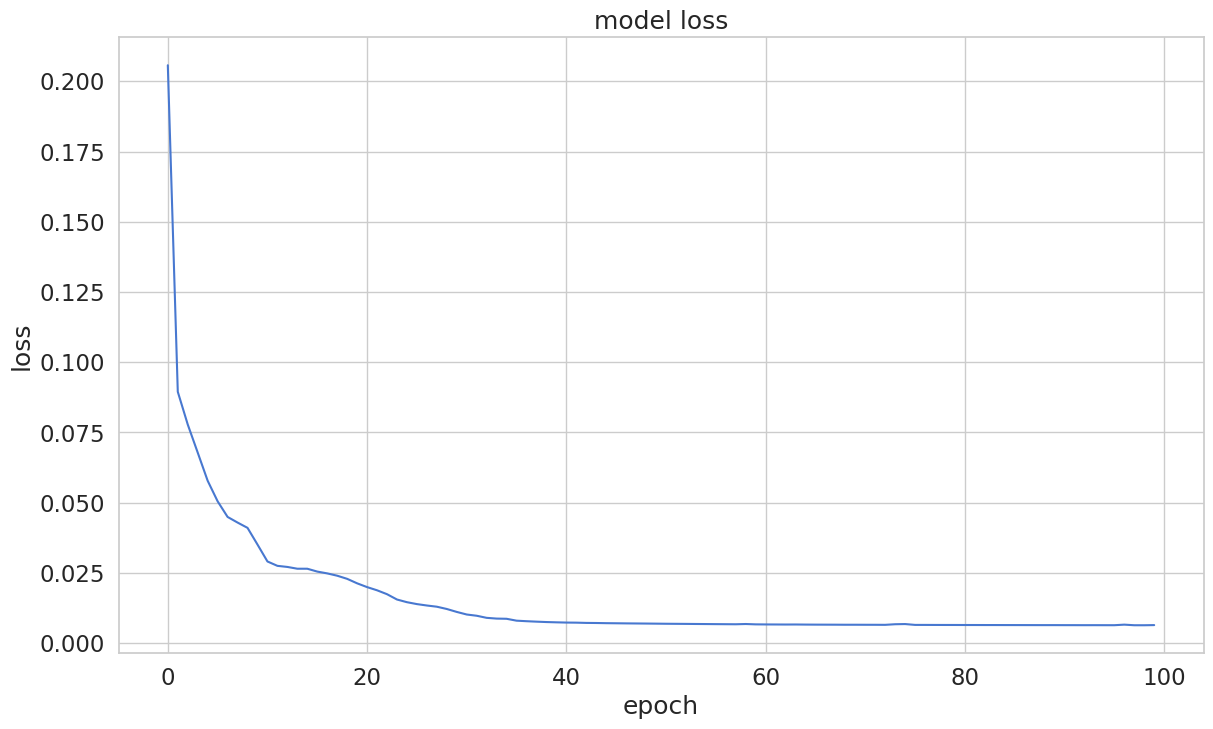

In [ ]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Оценка модели

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [ ]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,1001.000000,1001.000000
mean,0.001653,0.501499
std,0.005644,0.500248
min,0.000007,0.000000
25%,0.000105,0.000000
50%,0.000206,1.000000
75%,0.000582,1.000000
max,0.093898,1.000000


In [ ]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,1001.000000,1001.000000
mean,0.001653,0.501499
std,0.005644,0.500248
min,0.000007,0.000000
25%,0.000105,0.000000
50%,0.000206,1.000000
75%,0.000582,1.000000
max,0.093898,1.000000


Реконструкция ошибок без "Женщин" =)

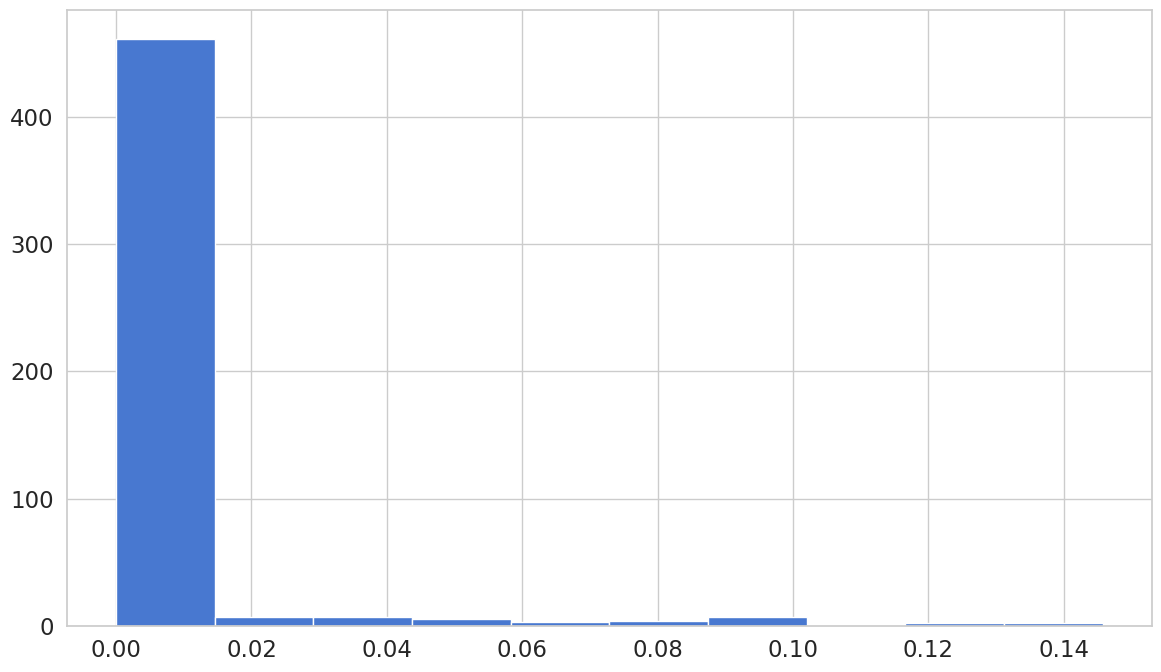

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

Реконструкция ошибок с "Женщинами" ==))

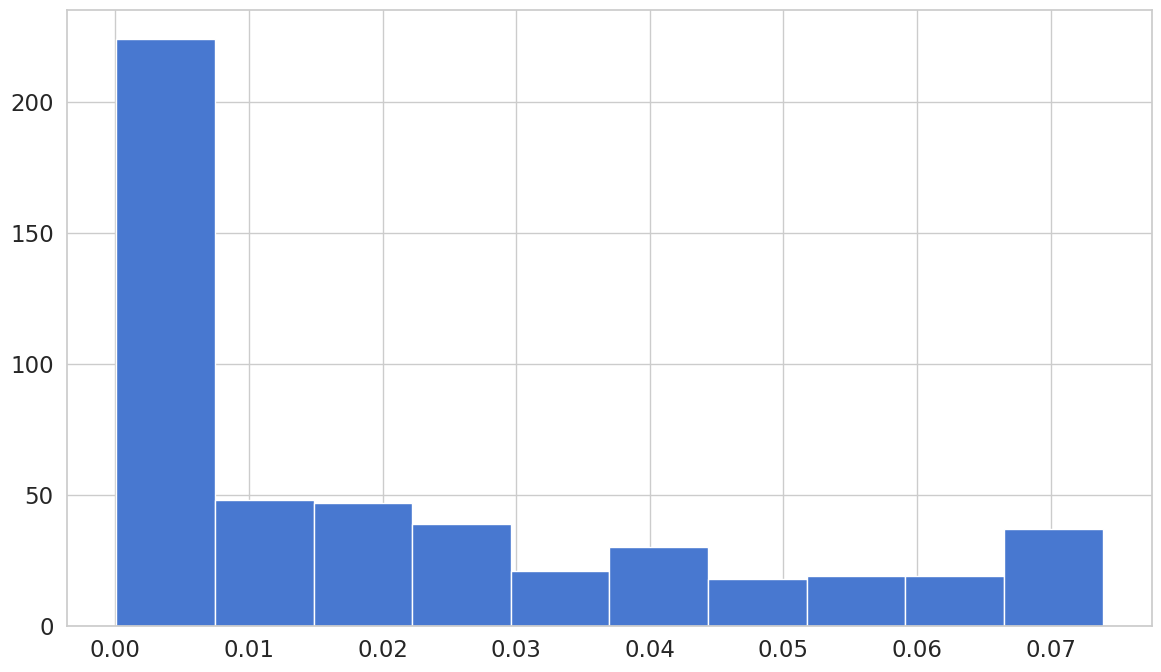

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

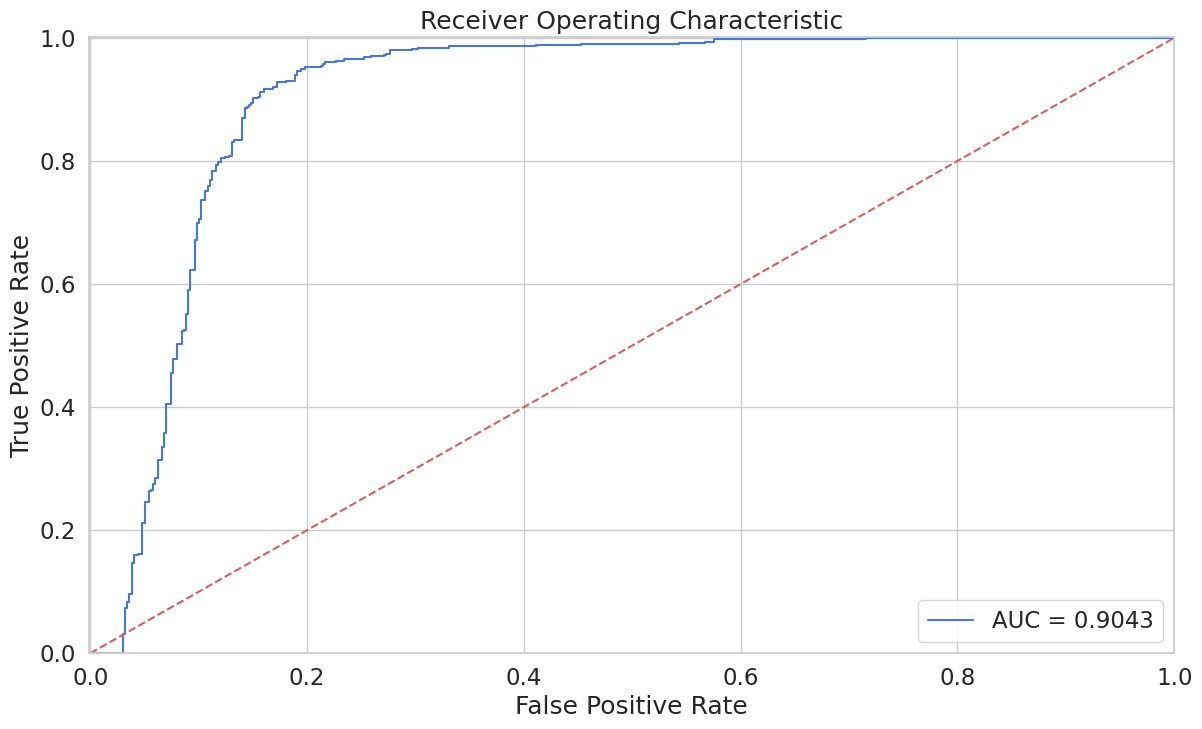

In [ ]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

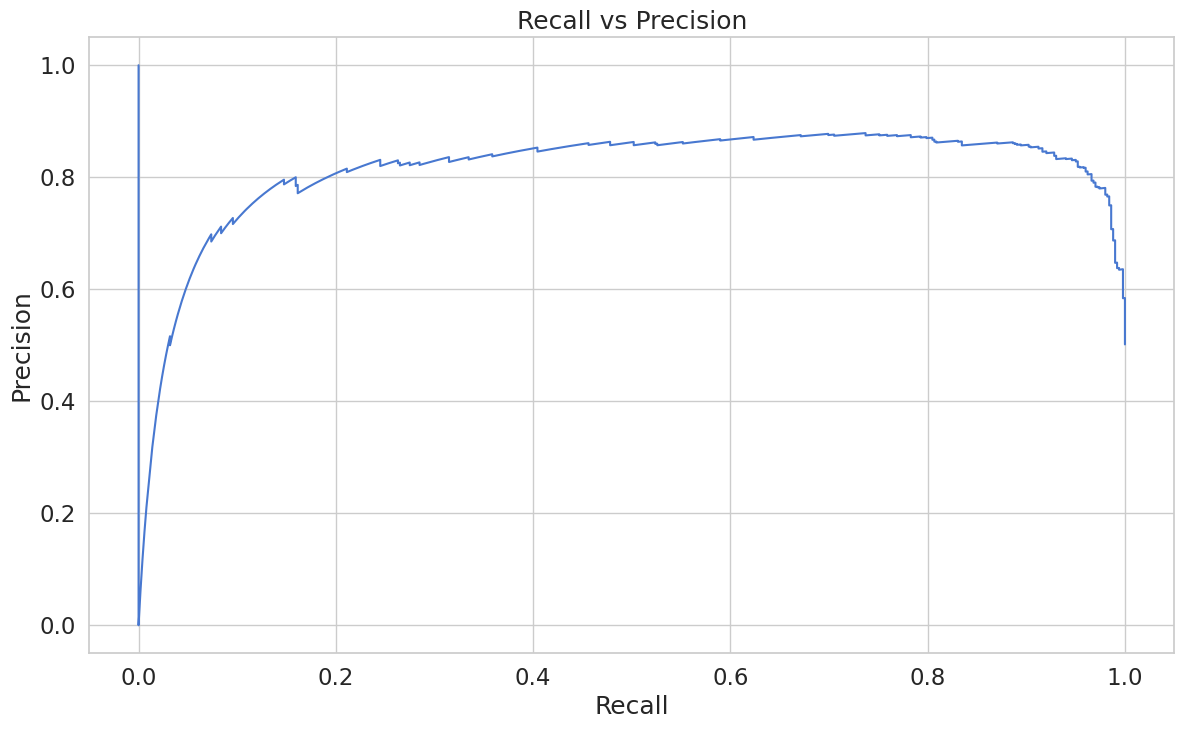

In [ ]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

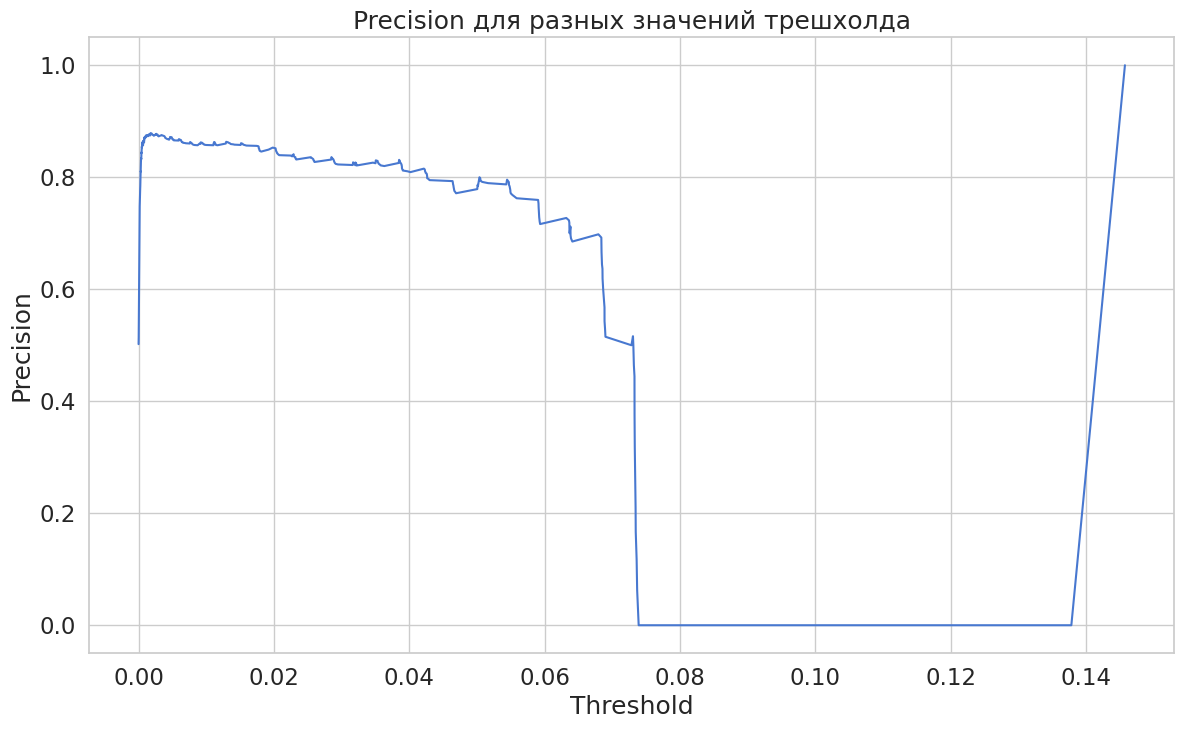

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


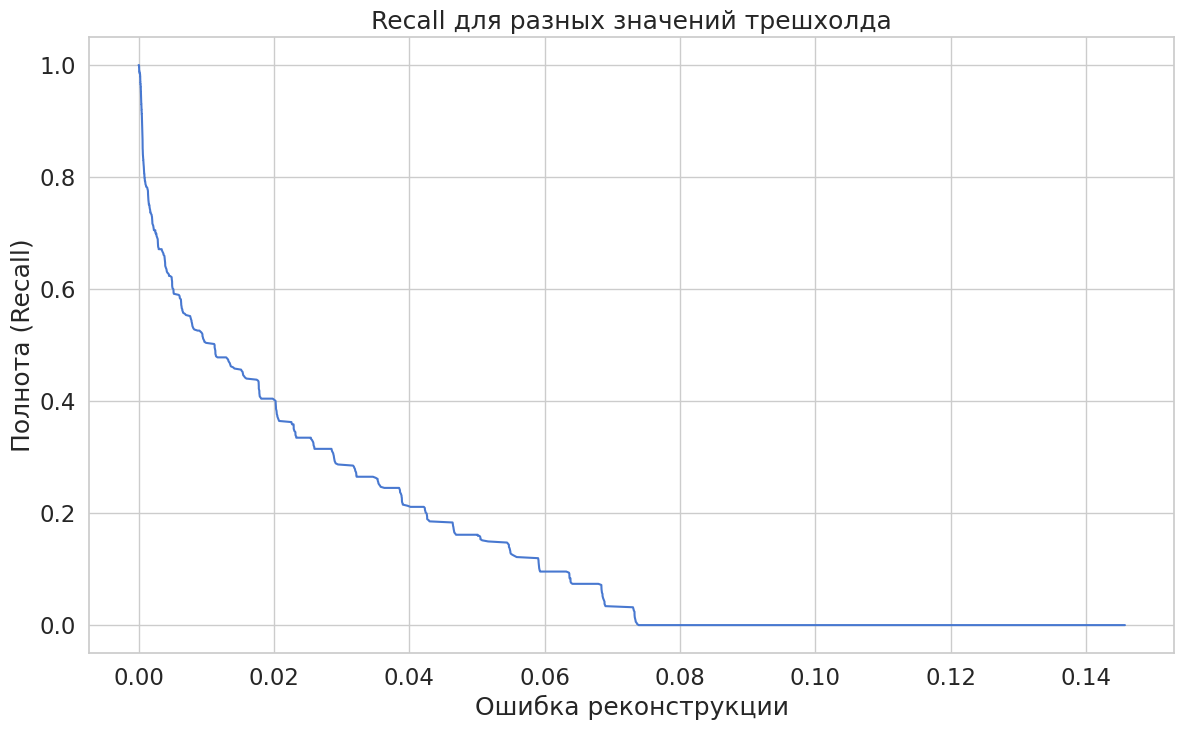

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать пол, мы рассчитаем ошибку реконструкции на основе самих данных. Если ошибка превышает предопределенный порог, мы помечаем ее как Female. Давайте выберем это значение:

In [ ]:
threshold = 0.0007

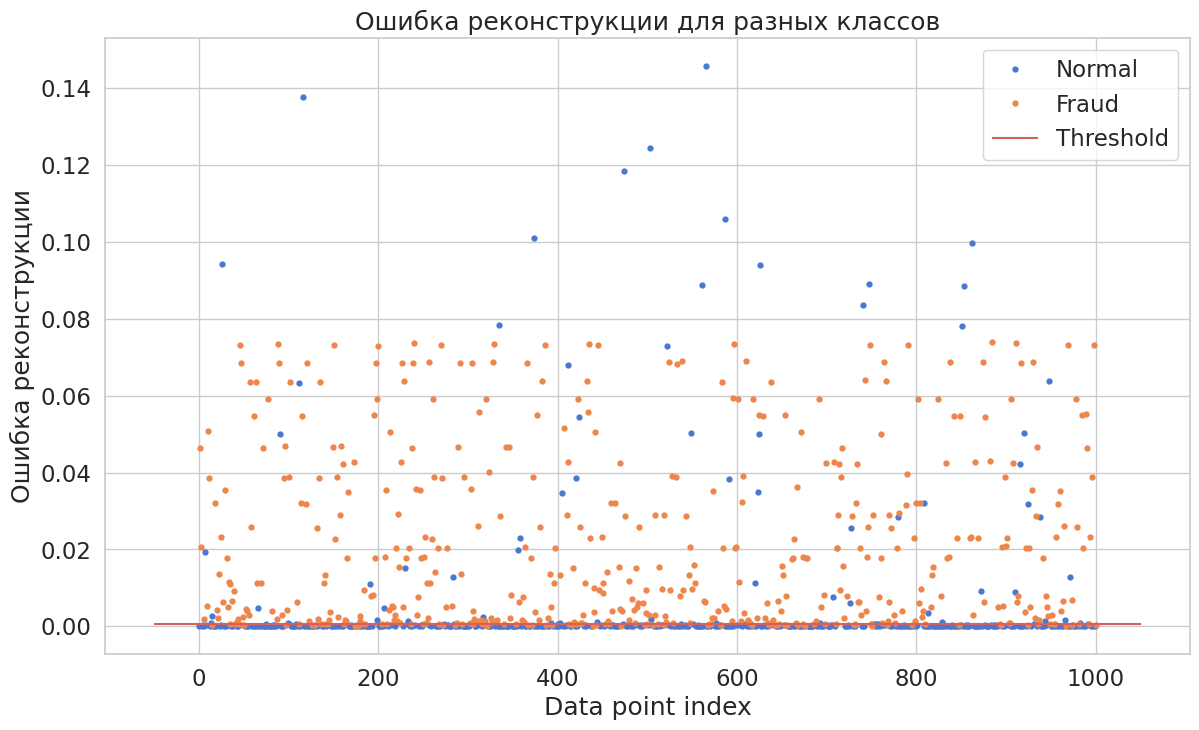

In [ ]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Female" if name == 1 else "Male")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-67-11f70cc5c840>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


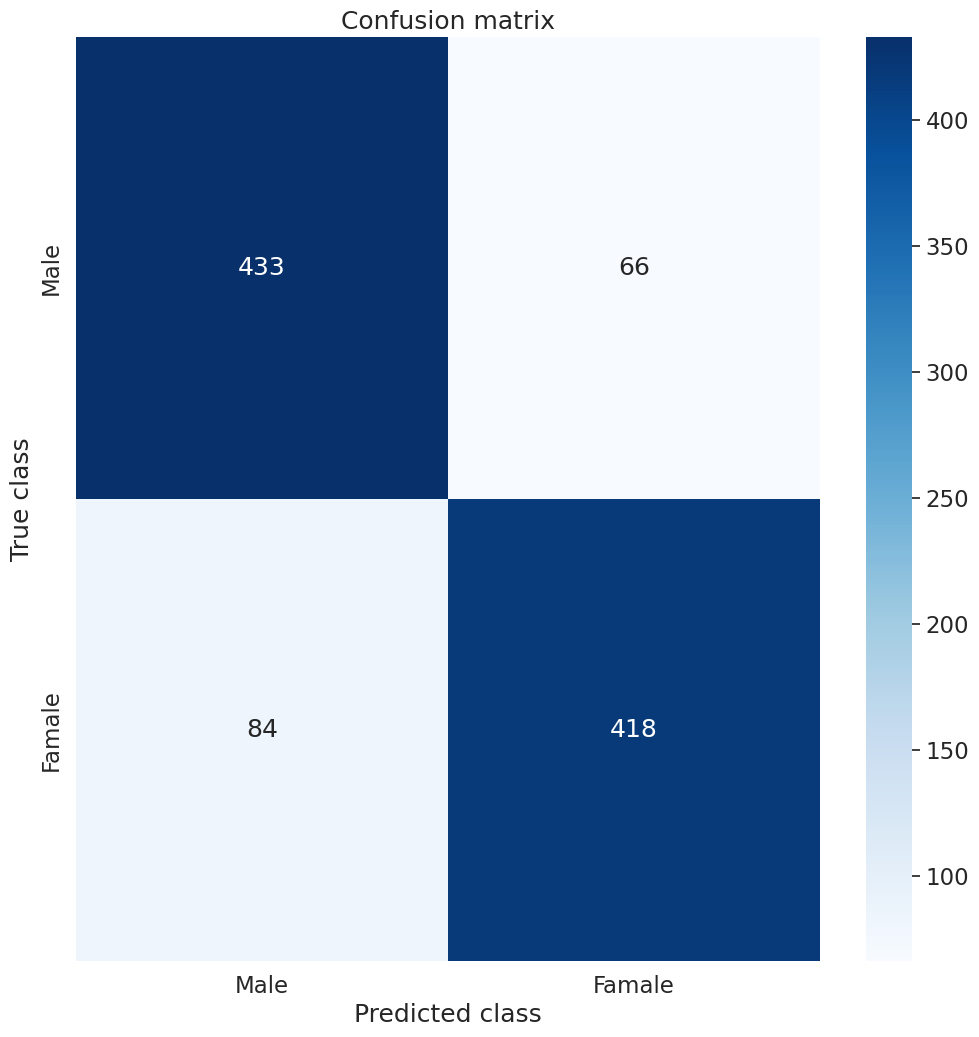

In [ ]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Выводы


Впринципе, наша модель модель неплохо определяет пол по признакам, но далеко не идеально